----
# ResNet-50 with Augmented Data
-----

### Summary:
Evaluating the performance of the ResNet-50 model when trained on augmented data. 

### Data Overview:
- **Dataset:** MNIST Sign Language Dataset
- **Number of Samples:** Approximately 1400 images per character
- **Image Dimensions:** Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Augmentation**:
    - Load augmented data.

- **Training my ResNet-50**:
   - Compile the model.
   - Train the model on augmented data

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.

### Data Augmentation Reminder:

- rescale=1./255             
    > Normalisation of the input data is best when working with neural networks
- rotation_range=20          
    > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      
    > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     
    > To ensure model is able to deal with off-centered images
- shear_range=0.2            
    > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             
    > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True       
    > To mimic opposite hand, if original image is left hand we can flip the image to show right hand

## Set Up
----

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import random

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Utility Functions
---

In [3]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''

    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

## Data Loading
----

In [4]:
X = joblib.load( '../../data/my_data/X.pkl')
y = joblib.load( '../../data/my_data/y.pkl')

In [5]:
X = X.reshape(-1,28,28)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [7]:
# Already know expected input size is 64 by 64 so we will resize here 
# No need to scale X values as scaling already done in data augmentation
X_train_resized = img_resize(X_train, 64, 64) 
X_val_resized = img_resize(X_val, 64, 64)

In [8]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

### Augmented data loading

In [9]:
train_datagen = joblib.load('../../data/my_data/train_datagen.pkl') 
val_datagen = joblib.load('../../data/my_data/val_datagen.pkl') 

In [10]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

## Training the Model
----

In [11]:
resnet_aug_model = load_model('../../model/my_models/ResNet_model.h5')

### Compile the model

In [12]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [13]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
resnet_aug_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

### Train the model using early stop to prevent overfitting

In [14]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [15]:
history = resnet_aug_model.fit(train_generator,
              steps_per_epoch=len(train_generator), # couldf be too small for resnet 
              epochs=50,
              validation_data=val_generator,
              validation_steps=len(val_generator),
              callbacks=[early_stop]
    )

Epoch 1/50


2024-07-07 15:55:52.886923: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


866/866 [==============================] - 109s 125ms/step - loss: 0.8779 - accuracy: 0.7498 - val_loss: 0.0590 - val_accuracy: 0.9830
Epoch 2/50
866/866 [==============================] - 108s 125ms/step - loss: 0.4660 - accuracy: 0.8484 - val_loss: 0.0514 - val_accuracy: 0.9847
Epoch 3/50
866/866 [==============================] - 119s 138ms/step - loss: 0.3895 - accuracy: 0.8708 - val_loss: 0.0525 - val_accuracy: 0.9830
Epoch 4/50
866/866 [==============================] - 126s 145ms/step - loss: 0.3479 - accuracy: 0.8842 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 4: early stopping


### Saving the model

In [16]:
resnet_aug_model.save('../../model/my_models/ResNet_augmented_model.h5')

### Assessing training and validation scores

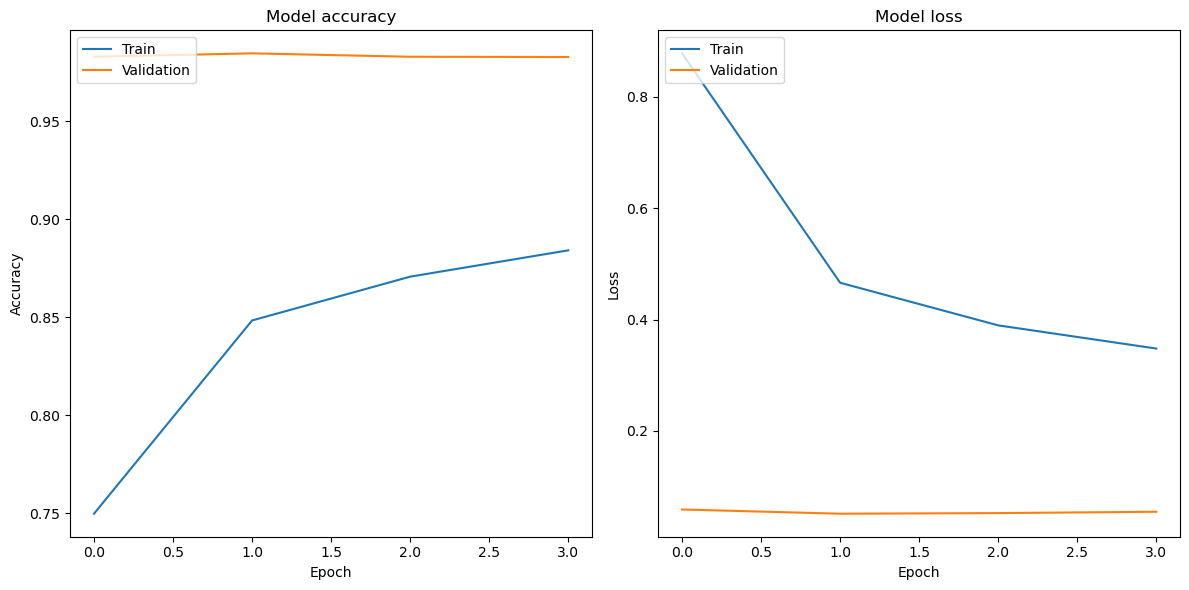

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Comment:**

As expected performance of ResNet with augmented data is not as good as base ResNet (with original data). However, there is a positive result, the validation score is higher than the training data sugggesting the model succesfully classified letters despite presence of augmentation in the dataset.

In comparison to the VGG with augmented data, we can see VGG is more capable to deal with the augmentation in the dataset as:

- ResNet-50 is a deeper network, it contains 50 layers. VGG has a smaller depth of 16 layers. This means that depsite ResNet 50 ability to discover more features due to its greater depth, it requires a large amount of data to effectively train and to be able to generalise to augmented images.

In [18]:
train_loss, train_acc = resnet_aug_model.evaluate(train_generator)
print(f'ResNet-50 with augmentation train score: {round(train_acc*100,4)}')

866/866 [==============================] - 109s 126ms/step - loss: 0.3255 - accuracy: 0.8927
ResNet-50 with augmentation train score: 89.2675


In [19]:
val_loss, val_acc = resnet_aug_model.evaluate(val_generator)
print(f'ResNet-50 with augmentation validation score: {round(val_acc*100,4)}')

217/217 [==============================] - 30s 136ms/step - loss: 0.0549 - accuracy: 0.9828
ResNet-50 with augmentation validation score: 98.2818


In [92]:
# val_loss, val_acc = resnet_aug_model.evaluate(X_val_resized, y_val)

  3/217 [..............................] - ETA: 19s - loss: 855.5672 - accuracy: 0.0208

217/217 [==============================] - 17s 80ms/step - loss: 838.9006 - accuracy: 0.0424


## Model Evaluation
-----

In [20]:
resnet_aug_model = load_model('../../model/my_models/ResNet_augmented_model.h5')

### Confusion Matrix

In [95]:
soft_pred = resnet_aug_model.predict(val_generator, batch_size=len(val_generator))
pred_y = np.argmax(soft_pred, axis=1)

  2/217 [..............................] - ETA: 19s

217/217 [==============================] - 21s 95ms/step


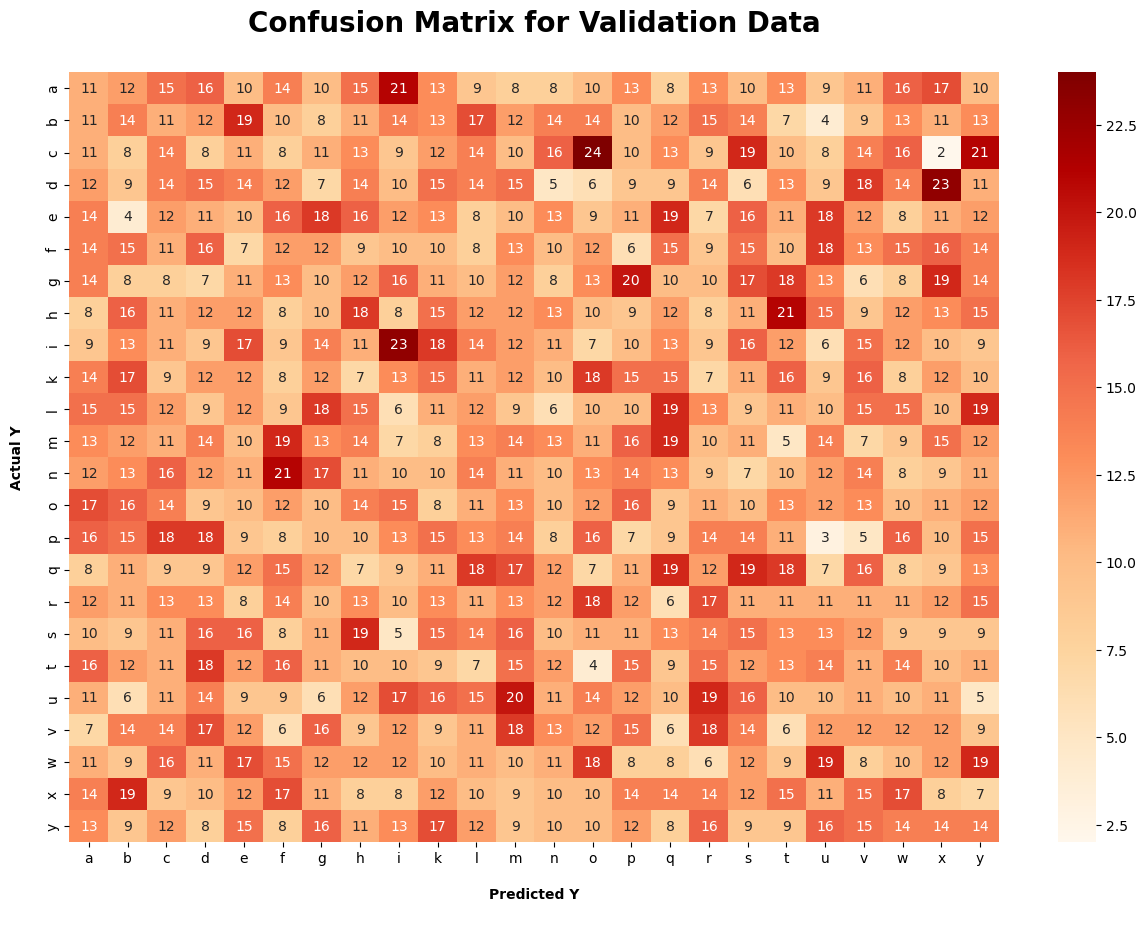

In [96]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Comment:**

This confusion matrix doesn't look correct.

I believe it is beacuse I am using y_val as actual y class, I think there must be a problem with the batching when using y_val or X_val_resized, this is something for me to investigate as I am not sure.

I also tried to create confusion matrix on X_val_resized predictions and y_val but the result also does not reflect the results I get when I evaluate the val_generator. Again this could be an issue with the batching.

217/217 [==============================] - 24s 109ms/step


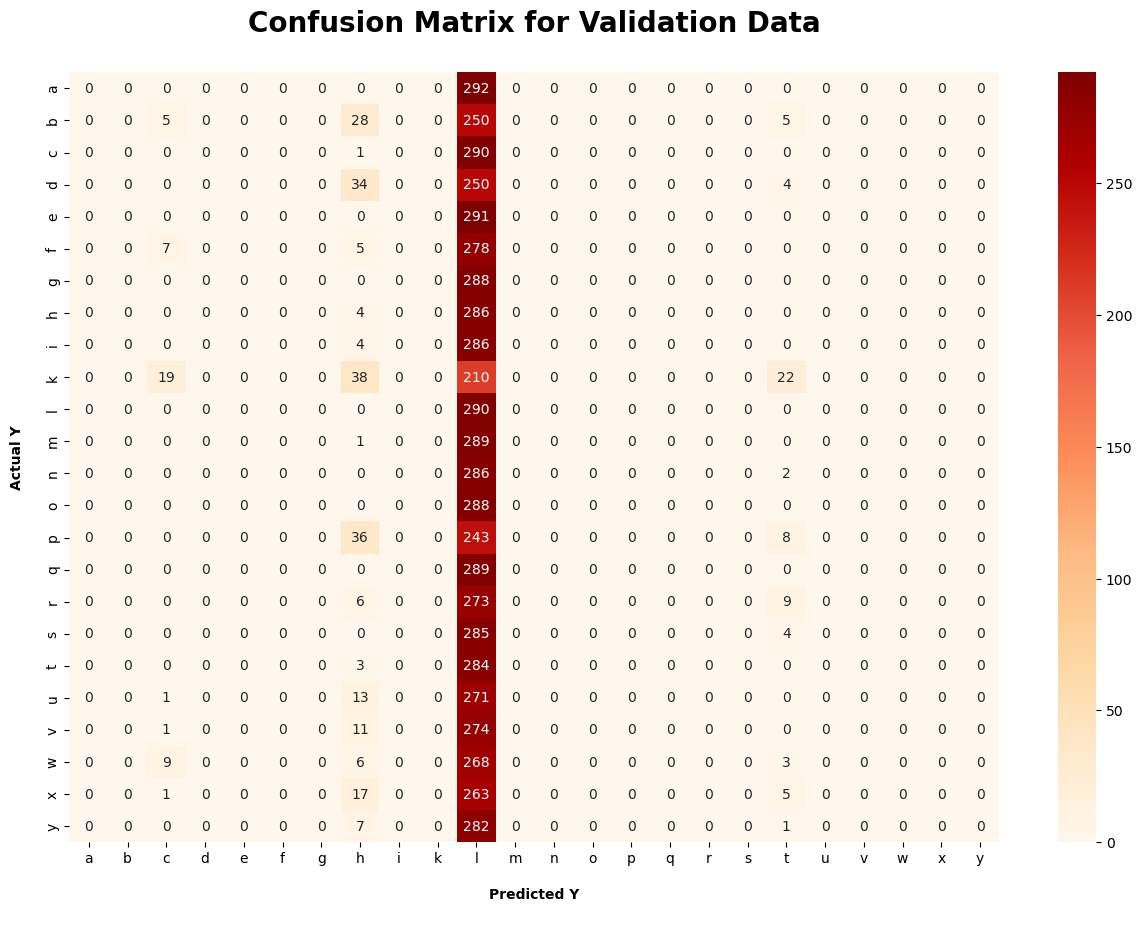

In [98]:
from sklearn.metrics import confusion_matrix
soft_pred = resnet_aug_model.predict(X_val_resized)
pred_y = np.argmax(soft_pred, axis=1)
# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Testing an Unseen Input Image

In [99]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(64, 64))
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

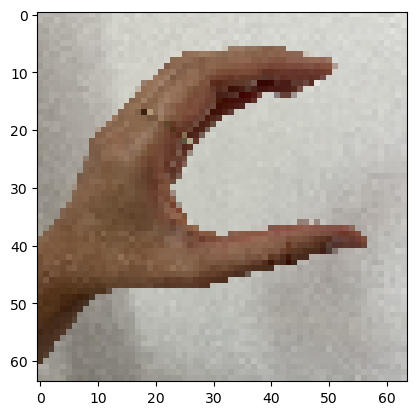

In [100]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [101]:
image_array = img_to_array(input_image)
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [102]:
soft_pred = resnet_aug_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 60ms/step


In [103]:
print(f'Prediction using ResNet trained with augmented data: \n{alphabet[pred_y[0]].upper()}')

Prediction using ResNet trained with augmented data: 
T


## Conclusion
-----

|                  | ResNet     | ResNet with augmentation |
|------------------|------------|--------------------------|
| Train Score      | 99.99      | 89.27                    |
| Validation Score | 99.88      | 98.28                    |  

The ResNet model trained on the original dataset also achieved almost 100% accuracy indicating performance on the original data was very strong. 

The ResNet model trained on augmented data performed worse since augmentation introduces some variability into the dataset which can cause the model to get confused.

ResNet 50 is a deep network and while that means it can detect a wide range of features it also makes it prone to overfitting if regularisation is not performed. Since we have an almost perfect score on the original data and worse training score on the augmented data it suggests the network could have been overfitting to the original data. 

In the future, I would re-run this network with some regularisation applied to see if this improves the training score on the augmented data.